In [1]:
import numpy as np 
import cv2 
import pandas as pd 
import skimage.io
import skimage.color
import sys
import os 
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(1, '../')
import sfunc as sf

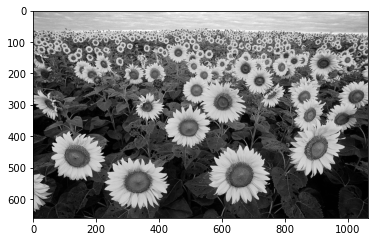

In [3]:
im = skimage.io.imread('sunflowers.jpg').astype(float)
imb = skimage.color.rgb2gray(im)
fig, ax = plt.subplots()
ax.imshow(imb, cmap='gray')

In [4]:
def gaussian1DKernel(sigma:int, scale:int=5 ):
    """
    sigma: stadard deviation of the gaussian distribution.
    scale: Range of x times the stadard deviatiion for the x values where we'll evaluate the gaussian.    
    Scale fixed to 5, following the rule of 3std = 99.7% of the data. We make sure we have at least that much.
    
    g: Gaussian distribution given a variance. Column Vector -> (n,1)
        
    If instead of doing it 1D we were doing 2D Kerels, would be much more computational expensive
    from run time O(2*n) --> O(n^2)
    """
    # Width of the Gaussian
    h = np.ceil(scale*sigma)
    x = np.arange(-h, h+1)
    
    # Cte of the Gaussian
    c = (1)/(np.sqrt(2*np.pi)*sigma)
    c_exp = np.exp((-x**2)/(2*sigma**2))
    
    # Gaussian equation 
    g = c*c_exp
    
    return g.reshape(-1,1)

In [5]:
def scaleSpace(im, sigma:int, n:int, retScales:bool=False):
    """
    Apply a Gaussian Kernel of width:
         sigma*2^i; 
    where:
         i = 0, 1, ..., n-1
    
    PARAMETERS 
    im -> image
    sigma -> variance of the gauusian kernel
    n -> range of the width of sigma.
    retScales -> Returns the Scales used if True  
    RETURNS
    im_scales-> pyramid of scales 
    """
    
    width = sigma*2**np.arange(n)
    im_scales = np.zeros((*im.shape, n))
    
    for i, scale in enumerate(width):
        g = gaussian1DKernel(scale)
        im_scales[:,:,i] = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)
    
    if retScales:
        return im_scales, width
    else:
        return im_scales

In [6]:
def differenceOfGaussian(im, sigma, n):
    """
    Calculates the differences of smothed images (or images convolved with different Gaussians)
    
    PARAMETERS
    im-> Image 
    sigma-> Variance for tha Gaussian filter 
    n-> max width of gauusian 
    Check scaleSpace function
    
    RETURNS
    DoG -> Differences of gaussians
    
    """

    I = scaleSpace(im, sigma, n)
    
    I_l = I[:,:,1:]
    I_r = I[:,:,:-1]
    
    DoG = I_l - I_r    
    
    return np.abs(DoG)

In [7]:
def circles(x, y, r:int=5, points:int=100):
    """
    Cretes the coordinates of a circle of a given radius and a specific center.
    
    
    PARAMETERS
    x -> x coordinate of the center of the circle, can be integer or array (n,)
         Can be index found with np.where 
    y -> y coordinate of the center of the circle, can be integer or array (n,)
         Can be index found with np.where 
    
    RETURNS
    Cx -> X coordinates of the circle (points, n)
    Cy -> Y coordinates of the circle (points, n)
    Beinng 
    """
    
    c_range = np.linspace(0, 2*np.pi, points).reshape(-1,1)

    if type(x) == int:
        print('integer')
        Cx = np.squeeze(np.array([x + r*np.cos(c_range)])).reshape(-1,1)
        Cy = np.squeeze(np.array([y + r*np.sin(c_range)])).reshape(-1,1)
    
    else:
        x = np.array(x)
        y = np.array(y)
        # Reshape arrays into desired dimensions
        x = sf.squeezdim(x).reshape(1, -1)
        y = sf.squeezdim(y).reshape(1, -1)
        
        Cx = np.squeeze(np.array([x + r*np.cos(c_range)]))
        Cy = np.squeeze(np.array([y + r*np.sin(c_range)]))
        
        try: 
            m,n = Cx.shape
            pass
        except ValueError:
            Cx = Cx.reshape(-1,1)
            Cy = Cy.reshape(-1,1)
    if not Cx.size:
        Cx = c_range*0
        Cy = c_range*0
    return Cx, Cy

## Extrema Localization

In [8]:
def nonMaxsupression4neig(I, boundaries:bool=False, eight:bool=False):
    """ 
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 4 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    col,row, d = I.shape
    
    # Create false columns and row for the columns and rows supressed 
    if boundaries:
        falsy_r = np.ones((col,d))
        falsy_c = np.ones((row,d))        
    else:
        falsy_r = np.zeros((col,d))
        falsy_c = np.zeros((row,d))
    # ToDo: Change var names, they are confusing, falsy_c should be a column vector
    # ToDo: optimize, code, when not using boundaries, it could be fatser not casting the falsy columns and rows 
    
    # Remember (columns x rows)
    # Upper neighbour
    # r(x, y) > r(x, y + 1)
    Up = I[:-1,:,:] >= I[1:,:,:]
    Up_f = np.zeros(I.shape)
    Up_f[-1,:,:] = falsy_c
    Up_f[:-1,:,:] = Up
    Up_f = Up_f == 1
    
    # Lower neighbour 
    # r(x, y) ≥ r(x, y − 1) 
    Low = I[1:,:,:] > I[:-1,:,:] 
    Low_f = np.zeros(I.shape)
    Low_f[0,:,:] = falsy_c
    Low_f[1:,:,:] = Low
    Low_f = Low_f == 1 
    
    # Right Neigbhour
    # r(x, y) > r(x + 1, y)
    Right = I[:,:-1,:] >= I[:,1:,:]
    Right_f = np.zeros(I.shape)
    Right_f[:,-1,:] = falsy_r
    Right_f[:,:-1,:] = Right 
    Right_f = Right_f == 1 
    
    # Left Neighbour 
    # r(x, y) ≥ r(x − 1, y)
    Left = I[:,1:,:] > I[:,:-1,:]
    Left_f = np.zeros(I.shape)
    Left_f[:,0,:] = falsy_r
    Left_f[:,1:,:] = Left
    Left_f = Left_f == 1
        
    # Find index where all conditions are True
    idx = np.where(Left_f & Right_f & Up_f & Low_f)
    # Create an empty image 
    I_tmp = np.zeros(I.shape)
    # Map the values that fulfill the condition on the empty matrix
    I_tmp[idx] = I[idx]
    
    if eight:
        # We want to use it in 8 neighbouts, return an array of Ture where condition is fullfiled
        return I_tmp != 0 
    else:
        return I_tmp

In [9]:
def nonMaxsupression8neig(I, boundaries:bool=False, boolean:bool=False):
    """
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 8 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    """
    
    # Not sure if we'll pass it with d dimensions 
    col,row, d = I.shape
    
    # Create false columns and row for the columns you erase 
    if boundaries:
        falsy_r = np.ones((col,d))
        falsy_c = np.ones((row,d))
    else:
        falsy_r = np.zeros((col,d))
        falsy_c = np.zeros((row,d))
    
       
    # Comparing Top left Corner
    TL = I[1:,1:,:] > I[:-1,:-1,:]
    TL_f = np.zeros(I.shape)
    TL_f[0,:,:] = falsy_c
    TL_f[:,0,:] = falsy_r
    TL_f[1:,1:,:] =  TL 
    TL_f = TL_f == 1
    
    # Comparing Top right Corner 
    TR = I[1:,:-1,:] >= I[:-1,1:,:]
    TR_f = np.zeros(I.shape)
    TR_f[0,:,:] = falsy_c
    TR_f[:,-1,:] = falsy_r
    TR_f[1:,:-1,:] = TR
    TR_f = TR_f == 1
    
    # Comparing Bottom Right Corner
    BR = I[:-1,:-1,:] >= I[1:,1:,:] 
    BR_f = np.zeros(I.shape)
    BR_f[-1,:,:] = falsy_c
    BR_f[:,-1,:] = falsy_r    
    BR_f[:-1,:-1,:] = BR
    BR_f = BR_f == 1
    
    # Comparing Bottom Left Corner 
    BL = I[:-1,1:,:] > I[1:,:-1,:]
    BL_f = np.zeros(I.shape)
    BL_f[-1,:,:] = falsy_c
    BL_f[:,0,:] = falsy_r
    BL_f[:-1,1:,:] = BL
    BL_f = BL_f == 1
    
    # Find index where conditions are fulfilled 
    idx_corners = np.where(TL_f & TR_f & BL_f & BR_f)
    # Create en empty ndarray    
    corners = np.zeros(I.shape)
    corners[idx_corners] = 1
    corners = corners == 1
    
    neig4 = nonMaxsupression4neig(I, eight=True)
    
    idx_8 = np.where(corners & neig4)
    
    neig8 = np.zeros(I.shape)
    neig8[idx_8] = I[idx_8]
    if boolean:
        return neig8 != 0 
    else:
        return neig8

### Multiple images 

In [10]:
def nonMaxsupression4neig_multilayer(Ilayer, Iabow, layer:str='above', boundaries:bool=False, eight:bool=False):
    """ 
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 4 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    
    Ilayer: Image we want to compare
    Iabow: I in layer above or below
    boundaries: False to detect peaks in boundaries False for not detecting 
    eight: True returns a boolean array, False returns the values that are peaks iin 4 nieghbour
    """
    
    # Check Images have the same dimension:
    if Ilayer.shape != Iabow.shape:
        print('Images introduced do not have the same dimensions')
        return False
    
    # Get the dimensions of the image 
    col,row = Ilayer.shape

    # Create false columns and rows so we can recreate thw image shape
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row

    # Differentiate if it's the layer above or the layer below 
    if layer.lower() == 'above':
        # Check if the pixel in layer l is higher than the pixel in layer l ± 1
        # ToDo: Greater or equal or greater?
        Itslef = Ilayer >= Iabow

        # Check if the pixel in layer l is higher than the Right Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x + 1, y)
        Right = Ilayer[:,:-1] >= Iabow[:,1:]
        Right = np.column_stack([Right, falsy_r])

        # Check if the pixel in layer l is higher than the Left Neigbhour pixel in layer l ± 1
        # rl(x, y) ≥ rl±1(x − 1, y)
        Left = Ilayer[:,1:] >= Iabow[:,:-1]
        Left = np.column_stack([falsy_r, Left])

        # Check if the pixel in layer l is higher than the Upper Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x, y + 1)
        Up = Ilayer[:-1,:] >= Iabow[1:,:]
        Up = np.vstack([Up, falsy_c])

        # Check if the pixel in layer l is higher than the Lower Neigbhour pixel in layer l ± 1
        # rl(x, y) ≥ rl±1(x, y − 1) 
        Low = Ilayer[1:,:] >= Iabow[:-1,:] 
        Low = np.vstack([falsy_c, Low])

        # Find index where all conditions are True
        idx = np.where(Itslef & Left & Right & Up & Low)
        # Create an empty image 
        I_tmp = np.zeros((col,row))
         # Map the values that fulfill the condition on the empty matrix
        I_tmp[idx] = Ilayer[idx]
        
    # If it's the layer below, we'll compare only grater     
    elif layer.lower() == 'below':
        # Check if the pixel in layer l is higher than the pixel in layer l ± 1
        # ToDo: Greater or equal or greater?
        Itslef = Ilayer > Iabow

        # Check if the pixel in layer l is higher than the Right Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x + 1, y)
        Right = Ilayer[:,:-1] > Iabow[:,1:]
        Right = np.column_stack([Right, falsy_r])

        # Check if the pixel in layer l is higher than the Left Neigbhour pixel in layer l ± 1
        # rl(x, y) ≥ rl±1(x − 1, y)
        Left = Ilayer[:,1:] > Iabow[:,:-1]
        Left = np.column_stack([falsy_r, Left])

        # Check if the pixel in layer l is higher than the Upper Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x, y + 1)
        Up = Ilayer[:-1,:] > Iabow[1:,:]
        Up = np.vstack([Up, falsy_c])

        # Check if the pixel in layer l is higher than the Lower Neigbhour pixel in layer l ± 1
        # rl(x, y) ≥ rl±1(x, y − 1) 
        Low = Ilayer[1:,:] > Iabow[:-1,:] 
        Low = np.vstack([falsy_c, Low])
    else:
        print('layer attribute must be above/below')
        return False 
    
        
    # Find index where all conditions are True
    idx = np.where(Itslef & Left & Right & Up & Low)
    # Create an empty image 
    I_tmp = np.zeros((col,row))
     # Map the values that fulfill the condition on the empty matrix
    I_tmp[idx] = Ilayer[idx]
    
    if eight:
        # We want to use it in 8 neighbouts, return an array of Ture where condition is fullfiled
        return I_tmp != 0
    else:
        return I_tmp

In [11]:
def nonMaxsupression8neig_multilayer(Ilayer, Iabow, layer:str='above', boundaries:bool=False, boolean: bool=False):
    """
    Apply Non maximum suppresion.
        (I(x, y) − I(x′, y′)) > 0 ∀ x′ ∈ N(x, y) 
    Where N(x, y) is a 8 neighbourhood around the point (x, y)
        (I(x, y) − I(x′, y′)) > 0 = (I(x, y) > I(x′, y′)
    
    Ilayer: Image we want to compare
    Iabow: I in layer above or below
    boundaries: False to detect peaks in boundaries False for not detecting 
    boolean: Return a Boolean Array if True and the numbers of the peaks if False. 
    
    """
    
    # Call 4 neighbour so we make checkings.
    neig4 = nonMaxsupression4neig_multilayer(Ilayer, Iabow, layer= layer, eight=True)
    
    shape = Ilayer.shape
    col,row = shape
    
    # Create false columns and row for the 
    falsy_r = [boundaries]*col
    falsy_c = [boundaries]*row
    
    if layer.lower() == 'above':
        # Check if the pixel in layer l is higher than the Top Left Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x-1, y-1)
        TL = Ilayer[1:,1:] >= Iabow[:-1,:-1]
        TL_f = np.zeros(shape)
        TL_f[0,:] = falsy_c
        TL_f[:,0] = falsy_r
        TL_f[1:,1:] =  TL 
        TL_f = TL_f == 1

        # Check if the pixel in layer l is higher than the Top Right Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x-1, y+1)
        TR = Ilayer[1:,:-1] >= Iabow[:-1,1:]
        TR_f = np.zeros(shape)
        TR_f[0,:] = falsy_c
        TR_f[:,-1] = falsy_r
        TR_f[1:,:-1] = TR
        TR_f = TR_f == 1

        # Check if the pixel in layer l is higher than the Bottom Right Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x+1, y+1)
        BR = Ilayer[:-1,:-1] >= Iabow[1:,1:] 
        BR_f = np.zeros(shape)
        BR_f[-1,:] = falsy_c
        BR_f[:,-1] = falsy_r    
        BR_f[:-1,:-1] = BR
        BR_f = BR_f == 1

        # Check if the pixel in layer l is higher than the Bottom Left Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x+1, y-1)
        BL = Ilayer[:-1,1:] >= Iabow[1:,:-1]
        BL_f = np.zeros(shape)
        BL_f[-1,:] = falsy_c
        BL_f[:,0] = falsy_r
        BL_f[:-1,1:] = BL
        BL_f = BL_f == 1
        
    elif layer.lower() == 'below':
        # Check if the pixel in layer l is higher than the Top Left Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x-1, y-1)
        TL = Ilayer[1:,1:] > Iabow[:-1,:-1]
        TL_f = np.zeros(shape)
        TL_f[0,:] = falsy_c
        TL_f[:,0] = falsy_r
        TL_f[1:,1:] =  TL 
        TL_f = TL_f == 1

        # Check if the pixel in layer l is higher than the Top Right Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x-1, y+1)
        TR = Ilayer[1:,:-1] > Iabow[:-1,1:]
        TR_f = np.zeros(shape)
        TR_f[0,:] = falsy_c
        TR_f[:,-1] = falsy_r
        TR_f[1:,:-1] = TR
        TR_f = TR_f == 1

        # Check if the pixel in layer l is higher than the Bottom Right Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x+1, y+1)
        BR = Ilayer[:-1,:-1] > Iabow[1:,1:] 
        BR_f = np.zeros(shape)
        BR_f[-1,:] = falsy_c
        BR_f[:,-1] = falsy_r    
        BR_f[:-1,:-1] = BR
        BR_f = BR_f == 1

        # Check if the pixel in layer l is higher than the Bottom Left Corner Neigbhour pixel in layer l ± 1
        # rl(x, y) > rl±1(x+1, y-1)
        BL = Ilayer[:-1,1:] > Iabow[1:,:-1]
        BL_f = np.zeros(shape)
        BL_f[-1,:] = falsy_c
        BL_f[:,0] = falsy_r
        BL_f[:-1,1:] = BL
        BL_f = BL_f == 1
    
    # Find index where conditions are fulfilled 
    idx_corners = np.where(TL_f & TR_f & BL_f & BR_f)
    # Create en empty ndarray of shape Image    
    corners = np.zeros(shape)
    corners[idx_corners] = 1
    corners = corners == 1
    
    idx_8 = np.where(corners & neig4)
    
    neig8 = np.zeros(shape)
    neig8[idx_8] = Ilayer[idx_8]
    
    if boolean:
        return neig8 != 0 
    else:
        return neig8

### SIFT 

In [12]:
def detectBlobs(im, sigma, n, threshold:float=0.8):
    """
    """
    
    # Obtain the scale used on the gaussians 
    _,scale = scaleSpace(im,sigma,n, retScales=True)
    
    # Calculate the difference of gaussians
    I_dog = differenceOfGaussian(im, sigma, n)
    
    # Get the number of images 
    d = I_dog.shape[-1]
    
    # Create an empty array of dimensions I_dog to stroe the peaks 
    I_peaks = np.zeros(I_dog.shape)
    
    # Compute peaks over images itself fast computation
    I_itself = nonMaxsupression8neig(I_dog, boolean=True)
    centers_x = np.array((), dtype=int)
    centers_y = np.array((), dtype=int)
    # Loop over the images abd calculate NonMaximum supresion
    for i in range(d):
        if not i:
            print('Layer: ', i)
            # First Layer, compare only with the next one. 
            above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], layer='above', boolean=True)
            itself = I_itself[:,:,i]
            # Find maximum value of the image, to apply threshold
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(above & itself & T)
            centers_x = np.append(centers_x, idx[0])
            centers_y = np.append(centers_y, idx[1])
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx, Cy = circles(idx[0], idx[1], scale[i])
            print(scale[i])
        elif i == d-1:
            print('Layer: ', i)
            # Last layer, compare only with the previuos one 
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], layer='below', boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(itself & below & T)
            centers_x = np.append(centers_x, idx[0])
            centers_y = np.append(centers_y, idx[1])
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx_tmp, Cy_tmp = circles(idx[0], idx[1], scale[i])
            Cx = np.concatenate([Cx, Cx_tmp], axis = 1)
            Cy = np.concatenate([Cy, Cy_tmp], axis = 1)
            
        else:
            print('Layer: ', i)
            # Layers inbetween 
            above = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i+1], layer='above', boolean=True)
            below = nonMaxsupression8neig_multilayer(I_dog[:,:,i], I_dog[:,:,i-1], layer='below', boolean=True)
            itself = I_itself[:,:,i]
            mx = np.max(I_dog[:,:,i])
            T = I_dog[:,:,i] > (threshold*mx)
            idx = np.where(above & itself & below & T)
            centers_x = np.append(centers_x, idx[0])
            centers_y = np.append(centers_y, idx[1])
            I_peaks[idx[0], idx[1], i] = I_dog[idx[0], idx[1], i]
            Cx_tmp, Cy_tmp = circles(idx[0], idx[1], scale[i])
            Cx = np.concatenate([Cx, Cx_tmp], axis = 1)
            Cy = np.concatenate([Cy, Cy_tmp], axis = 1)
            print(scale[i])
            
        
    return I_peaks, Cx, Cy, centers_x, centers_y

In [13]:
I_p, Cx, Cy, rx, ry = detectBlobs(imb, 0.7, 15)

Layer:  0
0.7
Layer:  1
1.4
Layer:  2
2.8
Layer:  3
5.6
Layer:  4
11.2
Layer:  5
22.4
Layer:  6
44.8
Layer:  7
89.6
Layer:  8
179.2
Layer:  9
358.4
Layer:  10
716.8
Layer:  11
1433.6
Layer:  12
2867.2
Layer:  13


In [44]:
rx.shape, ry.shape

((42,), (42,))

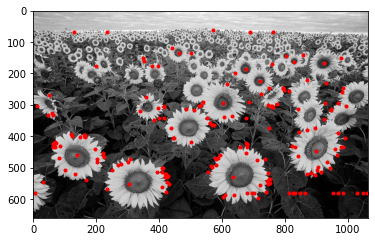

In [14]:
fig, ax = plt.subplots()
ax.imshow(imb, cmap='gray')
ax.plot(ry, rx, '.r')